# Multivariate Linear Regression with Gradient Descent

## Importing Libraries and Dataset

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [77]:
data = pd.read_csv('https://raw.githubusercontent.com/mk-gurucharan/Regression/master/Startups_Data.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [78]:
features = ['R&D Spend','Administration','Marketing Spend']
target = 'Profit'
X = data[features]
Y = data[target]

## Standardizing Data

In [79]:
sc = StandardScaler()
X_trans = sc.fit_transform(X)

## Modelling

In [134]:
def y_predict(weight, X, intercept):
    predicted_list = []
    for i in range(len(X)):
        predicted_list.append(np.dot(weight,X[i])+intercept)
    return np.array(predicted_list)

def MSE_loss_function(Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (Y[i] - Y_pred[i])**2
    return (1/length)*sum_value

def derivative_weight(X, Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (-X[i]*(Y[i] - Y_pred[i]))
    return (2/length)*sum_value

def derivative_bias(Y, Y_pred):
    length = len(Y)
    sum_value = 0
    for i in range(length):
        sum_value += (-(Y[i]-Y_pred[i]))
    return (2/length)*sum_value

def Gradient_Descent(X, Y):
    weight = np.random.randn(X.shape[1])
    intercept = 0
    epochs = 5000
    learning_rate = 0.002
    loss = []

    for _ in range(epochs):
        Y_pred = y_predict(weight, X, intercept)
        weight = weight - learning_rate * derivative_weight(X, Y, Y_pred)
        intercept = intercept - learning_rate * derivative_bias(Y, Y_pred)
        loss.append(MSE_loss_function(Y, Y_pred))
    
    # Plotting loss over epochs
    plt.plot(np.arange(1, epochs), loss[1:])
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")

    return weight, intercept


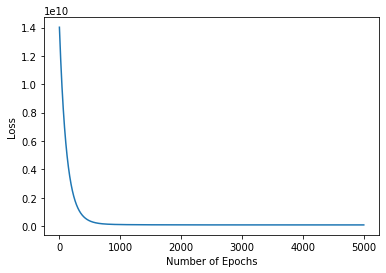

In [135]:
W, B= Gradient_Descent(X_trans, Y)

> Dapat dilihat, bahwa dengan metode **Gradient Descent**, model ini mampu meningkatkan performa model dengan baik

In [136]:
print(f'Weight : {W}')
print(f'Bias : {B}')

Weight : [36432.56544736  -680.42257163  3467.25454312]
Bias : 112012.63897820124


## Predict with the Model

In [137]:
def prediction(X_input):
    list = []
    for i in range(len(X_input)):
        list.append(np.dot(W,X_input[i]) + B)
    return np.array(list)

In [138]:
test_pred = prediction(X_trans)

## Comparing Ground Truth and Prediction

In [139]:
dataFrame_prediction = pd.DataFrame({
    'Ground Truth' : Y,
    'Prediction' : np.round(test_pred, 2)
})

dataFrame_prediction

,Ground Truth,Prediction
0,192261.83,192562.40
1,191792.06,189202.49
2,191050.39,182063.72
3,182901.99,173654.13
4,166187.94,172019.55
5,156991.12,163515.87
6,156122.51,157814.45
7,155752.60,160012.06
8,152211.77,151760.97
9,149759.96,154792.08


In [140]:
MSE_loss_function(Y, test_pred)

78431969.14472306